Comparing some quantities in VMEC wout to DESC in order to understand the formulas that went into the VMEC wout quantity (The internal variables in VMEC are a bit difficult to trace all the way to the output, so I found this to be quicker for me).

In [1]:
import numpy as np
import pytest
from netCDF4 import Dataset

import desc.examples
from desc.basis import DoubleFourierSeries, FourierZernikeBasis
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.examples import get
from desc.grid import Grid, LinearGrid, QuadratureGrid
from desc.input_reader import InputReader
from desc.io import load
from desc.objectives import ForceBalance, ObjectiveFunction
from desc.profiles import PowerSeriesProfile
from desc.transform import Transform
from desc.vmec import VMECIO
from desc.vmec_utils import (
    fourier_to_zernike,
    make_boozmn_output,
    ptolemy_identity_fwd,
    ptolemy_identity_rev,
    ptolemy_linear_transform,
    vmec_boundary_subspace,
    zernike_to_fourier,
)


In [2]:
vmecpath = "wout_GS_LH_ns256.nc"
descpath = "input.GS_LH_output.h5"

# desc_ncpath = "./wout_DESC_SOLOVEV_output.nc"

vmec = Dataset(vmecpath, mode="r")
eq = load(descpath)[-1]
# eq.change_resolution(M=vmec.variables["mpol"][:] - 1, N=vmec.variables["ntor"][:])
# VMECIO.save(
#     eq, desc_ncpath, surfs=vmec.variables["ns"][:], verbose=0
# )
# desc = Dataset(desc_ncpath, mode="r")

In [3]:
vmec.variables["over_r"]

<class 'netCDF4._netCDF4.Variable'>
float64 over_r(radius)
unlimited dimensions: 
current shape = (256,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [4]:
vmec.variables["ns"][:]

masked_array(data=256,
             mask=False,
       fill_value=999999,
            dtype=int32)

# over_r

Supposed to be 
$$
\begin{equation}
\tau = \partial R_\theta \partial Z_s -  \partial Z_\theta \partial R_s = \frac{\sqrt{g}}{R}
\end{equation}
$$


$$
\begin{equation}
overr = \frac{\langle \tau/R\rangle_{fsa}}{\frac{\partial V(s)}{\partial s}}
\end{equation}
$$

Where I To compute with DESC, everything that involves $\partial_s$ must be obtained by taking the corresponding DESC radially-derived quantitiy and multipy by $\frac{\partial \rho}{\partial s} = 1/(2\rho)$. So in DESC, we would have (where $\sqrt{g}_{DESC} = \mathbf{e}_{\rho} \cdot \mathbf{e}_{\theta} \times \mathbf{e}_{\zeta}$)

$$
\begin{equation}
\tau = \partial R_\theta \partial Z_\rho \frac{\partial \rho}{\partial s} -  \partial Z_\theta \partial R_\rho \frac{\partial \rho}{\partial s} = \frac{\sqrt{g}_{DESC} \frac{\partial \rho}{\partial s}}{R}
\end{equation}
$$


$$
\begin{equation}
overr = \frac{\langle \tau/R\rangle_{fsa}}{\frac{\partial V(\rho)}{\partial \rho} \frac{\partial \rho}{\partial s}} = \frac{\langle \frac{\sqrt{g}_{DESC} \frac{\partial \rho}{\partial s}}{R**2}\rangle_{fsa}}{\frac{\partial V(\rho)}{\partial \rho} \frac{\partial \rho}{\partial s}} = \frac{\langle \frac{\sqrt{g}_{DESC} }{R**2}\rangle_{fsa}}{\frac{\partial V(\rho)}{\partial \rho}}
\end{equation}
$$

However from the below, it seems that
- it is not a true flux-surface average but rather a simple average ($\langle ... \rangle = \iint ... d\theta d\zeta$ instead of $\langle ... \rangle_{fsa} =\iint ... \sqrt{g} d\theta d\zeta /\iint \sqrt{g} d\theta d\zeta $)
- and that it is not actually $\langle\tau/R\rangle$ but rather $\langle\sqrt{g}/R\rangle = \langle\tau\rangle$ that is the numerator of the output by VMEC (at least from the understanding of the documentation of $VMEC++$ which identifies $\tau$ with $G$ of Hirshman and Whitson 1983 eqn 17b)
- The $\partial V(s) / \partial s$ is the normalized one that is saved to the `"vp"` variable, namely it is really $\partial V(s) / \partial s / 4 / \pi^2$

So, the actual formula for the `"over_r"` quantity is the simple (not flux-surface) average over theta and zeta of the quantity $\sqrt{g}/R=\tau$ divided by the quantity $\partial V(s) / \partial s / 4 / \pi^2$:

$$
\begin{equation}
overr = \frac{\langle \sqrt{g}/R\rangle 4\pi^2}{\frac{\partial V(s)}{\partial s}} = \frac{\langle \tau\rangle 4\pi^2}{\frac{\partial V(s)}{\partial s}}
\end{equation}
$$

And in DESC the equivalent quantity is computed as 

$$
\begin{equation}
overr = \frac{\langle \sqrt{g}_{DESC}/R\rangle 4\pi^2}{\frac{\partial V(\rho)}{\partial \rho}}
\end{equation}
$$

Text(0, 0.5, 'Value')

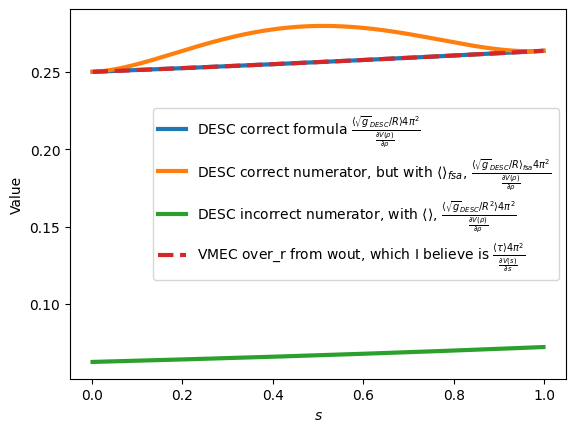

In [5]:
import matplotlib.pyplot as plt
from desc.grid import LinearGrid
from desc.integrals import surface_averages

M_grid = eq.M_grid
N_grid = eq.N_grid
NFP=eq.NFP
surfs=vmec.variables["ns"][:]
s_full = np.linspace(0, 1, surfs)
s_half = s_full[0:-1] + 0.5 / (surfs - 1)
r_full = np.sqrt(s_full)
r_half = np.sqrt(s_half)

grid_axis = LinearGrid(M=M_grid, N=N_grid, rho=np.array([0.0]), NFP=NFP)
grid_lcfs = LinearGrid(M=M_grid, N=N_grid, rho=np.array([1.0]), NFP=NFP)
grid_half = LinearGrid(M=M_grid, N=N_grid, NFP=NFP, rho=r_half)
grid_full = LinearGrid(M=M_grid, N=N_grid, NFP=NFP, rho=r_full)

data_quad = eq.compute(
    [
        "R0/a",
        "V",
        "W_B",
        "W_p",
        "<|B|>_rms",
        "<beta>_vol",
        "<beta_pol>_vol",
        "<beta_tor>_vol",
    ]
)
data_axis = eq.compute(["G", "p", "R", "<|B|^2>", "<|B|>"], grid=grid_axis)
data_lcfs = eq.compute(["G", "I", "R", "Z"], grid=grid_lcfs)
data_half = eq.compute(
    [
        "B_rho",
        "B_theta",
        "B_zeta",
        "G",
        "I",
        "J",
        "iota",
        "p",
        "sqrt(g)",
        "V_r(r)",
        "|B|",
        "<|B|^2>",
        "R","R_t","R_r","Z_t","Z_r"
    ],
    grid=grid_half,
)
# over_r is <(R_t Z_r - R_r Z_t)/R>_fsa / V'(rho) on half-grid
# over_r = file.createVariable("over_r", np.float64, ("radius",))
over_r_correct = np.insert(surface_averages(  
    grid_half,
    (data_half["R_t"] * data_half["Z_r"] - data_half["R_r"] * data_half["Z_t"]) / data_half["V_r(r)"],
    sqrt_g=1, # set to 1 here to do a simple average instead of a true flux surface average
    expand_out=False,
), [0], [0.0]) * 4 * np.pi**2  #/ np.concatenate([np.array([0.0]), vp])

over_r_correct = np.insert(surface_averages(  
    grid_half,
    data_half["sqrt(g)"] / data_half["R"] / data_half["V_r(r)"],
    sqrt_g=1, # set to 1 here to do a simple average instead of a true flux surface average
    expand_out=False,
), [0], [0.0]) * 4 * np.pi**2  #/ np.concatenate([np.array([0.0]), vp])



over_r_correct_num_wrong_average = np.insert(surface_averages(  
    grid_half,
    (data_half["R_t"] * data_half["Z_r"] - data_half["R_r"] * data_half["Z_t"]) / data_half["V_r(r)"],
    sqrt_g=data_half["sqrt(g)"], # set to 1 here to do a simple average instead of a true flux surface average
    expand_out=False,
), [0], [0.0]) * 4 * np.pi**2  #/ np.concatenate([np.array([0.0]), vp])

over_r_incorrect_num_right_average = np.insert(surface_averages(  
    grid_half,
    (data_half["R_t"] * data_half["Z_r"] - data_half["R_r"] * data_half["Z_t"]) / data_half["R"] / data_half["V_r(r)"],
    sqrt_g=1, # set to 1 here to do a simple average instead of a true flux surface average
    expand_out=False,
), [0], [0.0]) * 4 * np.pi**2  #/ np.concatenate([np.array([0.0]), vp])



plt.figure()
plt.plot(s_half, over_r_correct[1:]  ,label=r"DESC correct formula $\frac{\langle \sqrt{g}_{DESC}/R\rangle 4\pi^2}{\frac{\partial V(\rho)}{\partial \rho}}$", lw=3)
plt.plot(s_half, over_r_correct_num_wrong_average[1:]  ,label=r"DESC correct numerator, but with $\langle \rangle_{fsa}$, $\frac{\langle \sqrt{g}_{DESC}/R\rangle_{fsa} 4\pi^2}{\frac{\partial V(\rho)}{\partial \rho}}$ ", lw=3)
plt.plot(s_half, over_r_incorrect_num_right_average[1:]  ,label=r"DESC incorrect numerator, with $\langle \rangle$, $\frac{\langle \sqrt{g}_{DESC}/R^2\rangle 4\pi^2}{\frac{\partial V(\rho)}{\partial \rho}}$ ", lw=3)
plt.plot(s_half, vmec["over_r"][1:],"--",label=r"VMEC over_r from wout, which I believe is $\frac{\langle \tau\rangle 4\pi^2}{\frac{\partial V(s)}{\partial s}}$", lw=3)
plt.legend()
plt.xlabel(r"$s$")
plt.ylabel("Value")


# jcurv

# jdotb